In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

## SMCNOD Data

In [35]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
c7 = table_cut["pmra_error"] < 0.5
high_quality = (c1 | c2) & c3 & c4 & c6 & c7
table_cut = table_cut[high_quality]
tab = table_cut

In [36]:
len(tab)

290

In [37]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

In [38]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
pmnorm

0.00321486128053276

Text(0.5, 0, '[Fe/H]')

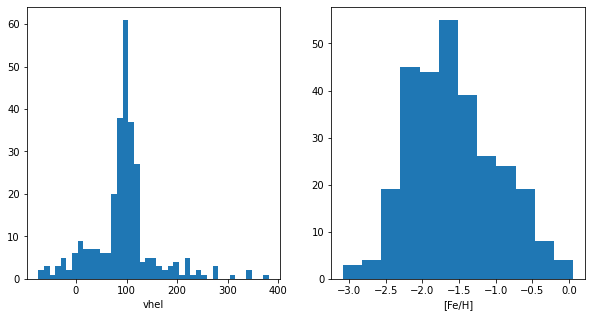

In [146]:
fig1, axes1 = plt.subplots(1, 2, figsize=(10, 5))

axes1[0].hist(rv, bins='auto')
axes1[0].set_xlabel("vhel")

axes1[1].hist(feh, bins='auto')
axes1[1].set_xlabel("[Fe/H]")

Text(0.5, 0, 'pmdec')

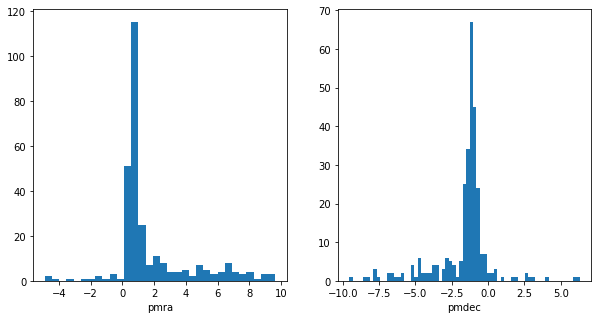

In [147]:
fig1, axes1 = plt.subplots(1, 2, figsize=(10, 5))
axes1[0].hist(pmra, bins='auto')
axes1[0].set_xlabel("pmra")

axes1[1].hist(pmdec, bins='auto')
axes1[1].set_xlabel("pmdec")

Text(0, 0.5, 'vhel')

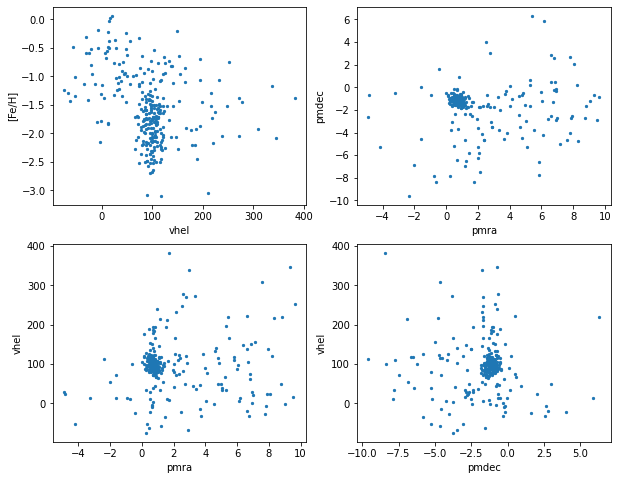

In [148]:
fig2, axes2 = plt.subplots(2, 2, figsize=(10, 8))

axes2[0, 0].scatter(rv, feh, s=5)
axes2[0, 0].set_xlabel("vhel")
axes2[0, 0].set_ylabel("[Fe/H]")

axes2[0, 1].scatter(pmra, pmdec, s=5)
axes2[0, 1].set_xlabel("pmra")
axes2[0, 1].set_ylabel("pmdec")

axes2[1, 0].scatter(pmra, rv, s=5)
axes2[1, 0].set_xlabel("pmra")
axes2[1, 0].set_ylabel("vhel")

axes2[1, 1].scatter(pmdec, rv, s=5)
axes2[1, 1].set_xlabel("pmdec")
axes2[1, 1].set_ylabel("vhel")

In [97]:
np.log10(16)

1.2041199826559248

# Likelihood function

In [149]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2",
                "pmra","pmdec","lsigpmra","lsigpmdec",
                "pmra1","pmdec1","lsigpmra1","lsigpmdec1",
                "pmra2","pmdec2","lsigpmra2","lsigpmdec2"]
def full_like(theta):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal, lsigpmra, lsigpmdec, \
    pmra1, pmdec1, lsigpmra1, lsigpmdec1, \
    pmra2, pmdec2, lsigpmra2, lsigpmdec2 = theta
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50) or (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2) or \
        (abs(pmra1) > 10) or (abs(pmdec1) > 10) or (abs(pmra2) > 10) or (abs(pmdec2) > 10) or \
        (lsigpmra1 > 1.3) or (lsigpmra1 < -1) or (lsigpmra2 > 1.3) or (lsigpmra2 < -1) or \
        (lsigpmra > 1.3) or (lsigpmra < -1) or (lsigpmdec > 1.3) or (lsigpmdec < -1) or \
        (lsigpmdec1 > 1.3) or (lsigpmdec1 < -1) or (lsigpmdec2 > 1.3) or (lsigpmdec2 < -1):
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    # Compute log likelihood in pmra
    lgal_pmra = stats.norm.logpdf(pmra, loc=pmra_gal, scale=np.sqrt(pmraerr**2 + (10**lsigpmra)**2))
    lbg1_pmra = stats.norm.logpdf(pmra, loc=pmra1, scale=np.sqrt(pmraerr**2 + (10**lsigpmra1)**2))
    lbg2_pmra = stats.norm.logpdf(pmra, loc=pmra2, scale=np.sqrt(pmraerr**2 + (10**lsigpmra2)**2))
    
    # Compute log likelihood in pmdec
    lgal_pmdec = stats.norm.logpdf(pmdec, loc=pmdec_gal, scale=np.sqrt(pmdecerr**2 + (10**lsigpmdec)**2))
    lbg1_pmdec = stats.norm.logpdf(pmdec, loc=pmdec1, scale=np.sqrt(pmdecerr**2 + (10**lsigpmdec1)**2))
    lbg2_pmdec = stats.norm.logpdf(pmdec, loc=pmdec2, scale=np.sqrt(pmdecerr**2 + (10**lsigpmdec2)**2))
    
    # Combine the components
    lgal = np.log(pgal)+lgal_vhel+lgal_pmra+lgal_pmdec+lgal_feh
    lbg1 = np.log(pbg1)+lbg1_vhel+lbg1_pmra+lbg1_pmdec+lbg1_feh
    lbg2 = np.log(1-pbg1)+lbg2_vhel+lbg2_pmra+lbg2_pmdec+lbg2_feh
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal)+lbgtot)
    return ltot.sum()

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [208]:
def project_model(theta, rvmin=-100, rvmax=400, fehmin=-3, fehmax=0, pmramin=-5, pmramax=10, pmdecmin=-10, pmdecmax=7):
    """ Turn parameters into distributions for RV, metallicity, and proper motions """
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    pmraarr = np.linspace(pmramin, pmramax, 1000)
    pmdecarr = np.linspace(pmdecmin, pmdecmax, 1000)
    params = get_paramdict(theta)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    
    ppmra0 = params["pgal"]*stats.norm.pdf(pmraarr, loc=params["pmra"], scale=10**params["lsigpmra"])
    ppmra1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(pmraarr, loc=params["pmra1"], scale=10**params["lsigpmra1"])
    ppmra2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(pmraarr, loc=params["pmra2"], scale=10**params["lsigpmra2"])
    
    ppmdec0 = params["pgal"]*stats.norm.pdf(pmdecarr, loc=params["pmdec"], scale=10**params["lsigpmdec"])
    ppmdec1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(pmdecarr, loc=params["pmdec1"], scale=10**params["lsigpmdec1"])
    ppmdec2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(pmdecarr, loc=params["pmdec2"], scale=10**params["lsigpmdec2"])
    
    return rvarr, prv0, prv1, prv2, feharr, pfe0, pfe1, pfe2, pmraarr, ppmra0, ppmra1, ppmra2, pmdecarr, ppmdec0, ppmdec1, ppmdec2


In [234]:
def plot_1d_distrs(theta):
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)
    fig, axes = plt.subplots(2,2,figsize=(10,5))
    
    ax = axes[0,0]
    ax.hist(rv, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="vhel (km/s)", ylabel="Prob. Density")
    ax.legend(fontsize='small')

    ax = axes[0,1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")
    
    ax = axes[1,0]
    ax.hist(pmra, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[8:12]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="pmra", ylabel="Prob. Density")
    
    ax = axes[1,1]
    ax.hist(pmdec, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[12:16]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="pmdec", ylabel="Prob. Density")
    return fig

In [238]:
def plot_2d_distr(theta):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)
    ax.grid()
    
    ax = axes[1]
    ax.plot(pmra, pmdec, 'k.')
    ax.set(xlabel="pmra", ylabel="pmdec")    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["pmra"], params["pmdec"],
               xerr=2*10**params["lsigpmra"], yerr=2*10**params["lsigpmdec"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["pmra1"], params["pmdec1"],
               xerr=2*10**params["lsigpmra1"], yerr=2*10**params["lsigpmdec1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["pmra2"], params["pmdec2"],
               xerr=2*10**params["lsigpmra2"], yerr=2*10**params["lsigpmdec2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)
    ax.grid()

# Optimize parameters



In [229]:
## I found this guess by looking at the plot by eye and estimating. This part requires some futzing.
p0_guess = [0.47, 0.1,
            102, 1.1, -1.9,-0.5,
            196, 1.5, -2, -0.37,
            46, 2, -0.1, -0.3,
            0.7, -1.1,-0.9, -0.9,
            0.75, -1, -0.6, -0.6,
            3.5, -2.5, 0.5, 0.5]

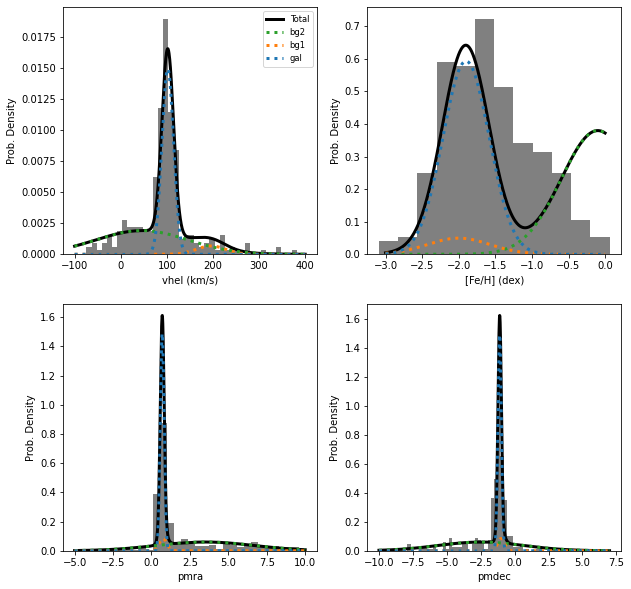

In [230]:
fig1 = plot_1d_distrs(p0_guess)

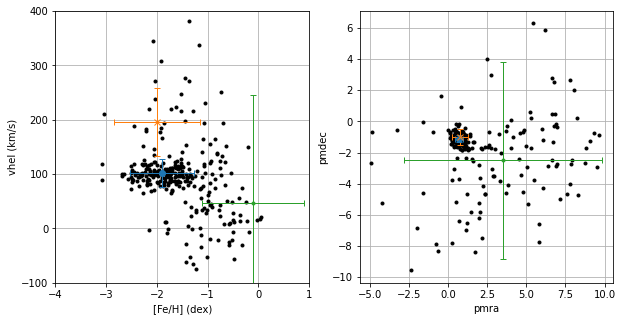

In [239]:
fig2 = plot_2d_distr(p0_guess)

In [154]:
optfunc = lambda theta: -full_like(theta)

In [155]:
%timeit optfunc(p0_guess)

1.41 ms ± 4.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [156]:
optfunc(p0_guess)

2725.9139892225235

In [157]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 7.05 s, sys: 155 ms, total: 7.2 s
Wall time: 7.21 s


In [158]:
res.x

array([ 5.72312198e-01,  9.15231746e-02,  9.84399597e+01,  1.14431181e+00,
       -1.84694052e+00, -5.10845118e-01,  1.85858164e+02,  1.43292425e+00,
       -1.69771804e+00, -1.02287995e-01,  4.99468778e+01,  1.99340551e+00,
       -1.01006408e+00, -3.13903315e-01,  7.13929377e-01, -1.12956354e+00,
       -9.72533317e-01, -9.77365887e-01,  9.14403512e-01, -8.77373205e-01,
       -2.42498911e-01, -2.06127832e-01,  3.15810849e+00, -2.47679585e+00,
        5.11444624e-01,  4.45835322e-01])

In [159]:
optfunc(res.x)

2434.16987690532

In [160]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

pgal: 0.572
pbg1: 0.092
vhel: 98.440
lsigv: 1.144
feh: -1.847
lsigfeh: -0.511
vbg1: 185.858
lsigvbg1: 1.433
fehbg1: -1.698
lsigfeh1: -0.102
vbg2: 49.947
lsigvbg2: 1.993
fehbg2: -1.010
lsigfeh2: -0.314
pmra: 0.714
pmdec: -1.130
lsigpmra: -0.973
lsigpmdec: -0.977
pmra1: 0.914
pmdec1: -0.877
lsigpmra1: -0.242
lsigpmdec1: -0.206
pmra2: 3.158
pmdec2: -2.477
lsigpmra2: 0.511
lsigpmdec2: 0.446


## Posterior Sampling
The posterior is sampled using `emcee` with 64 walkers and 10,000 steps per chain.

In [161]:
nw = 64
p0 = res['x']
nit = 2000
ep0 = np.zeros(len(p0_guess)) + 0.02
p0s = np.random.multivariate_normal(p0_guess, np.diag(ep0)**2, size=nw)
print(p0s)

[[  0.46635099   0.57685977 101.98026041 ...  -2.50172568   0.54224912
    0.51904794]
 [  0.48569545   0.57871952 101.97766288 ...  -2.49995389   0.49539198
    0.47304452]
 [  0.47909168   0.53179032 101.99186608 ...  -2.51657489   0.48158098
    0.53699557]
 ...
 [  0.44263796   0.56088247 101.98541067 ...  -2.49616042   0.51948414
    0.51385306]
 [  0.43630857   0.55183941 101.9722797  ...  -2.51477123   0.47290693
    0.50961349]
 [  0.4913633    0.57102282 101.99387875 ...  -2.45432926   0.4943904
    0.55933934]]


In [162]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

26


In [163]:
def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
#from schwimmbad import MultiPool
#pool = MultiPool(4)
es = emcee.EnsembleSampler(
    nw, len(p0_guess), full_like)

In [164]:
%time PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
es.reset()

CPU times: user 2min 27s, sys: 3.05 s, total: 2min 30s
Wall time: 2min 30s


In [165]:
%time es.run_mcmc(PP.coords, nit, rstate0=get_rstate())

CPU times: user 2min 4s, sys: 2.6 s, total: 2min 7s
Wall time: 2min 7s


State([[ 5.10897084e-01  9.14848945e-02  9.54972208e+01 ... -2.39010067e+00
   4.90947803e-01  4.55716153e-01]
 [ 5.31559838e-01  1.18192448e-01  1.00383738e+02 ... -2.26462815e+00
   5.65595745e-01  4.40844690e-01]
 [ 5.36621970e-01  7.39788843e-02  9.58097169e+01 ... -2.51276355e+00
   5.61150300e-01  4.84907771e-01]
 ...
 [ 5.03373836e-01  7.35112341e-02  9.89663829e+01 ... -2.61908306e+00
   4.76183681e-01  4.83564363e-01]
 [ 5.34827862e-01  1.00779439e-01  1.01321690e+02 ... -2.52605760e+00
   4.98494809e-01  4.78602269e-01]
 [ 5.57708361e-01  1.63986340e-01  9.73897855e+01 ... -2.51282741e+00
   5.06297746e-01  4.27661394e-01]], log_prob=[-2439.48973918 -2436.62711123 -2442.69708074 -2435.92538389
 -2435.35916572 -2437.54534866 -2436.37989884 -2437.37445125
 -2440.05314335 -2439.93041901 -2438.97159917 -2440.2425324
 -2438.57760245 -2437.50760446 -2440.61703345 -2435.74759953
 -2441.12342959 -2438.74654003 -2446.39463582 -2445.86649819
 -2437.38463885 -2437.21288578 -2450.5382975

In [166]:
outputs = es.flatchain

### Acceptance fraction
Judging the convergence and performance of an algorithm is a non-trival problem. As a rule of thumb, the acceptance fraction should be between 0.2 and 0.5 (for example, Gelman, Roberts, & Gilks 1996).

In [167]:
# Another good test of whether or not the sampling went well is to 
# check the mean acceptance fraction of the ensemble
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(es.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.211


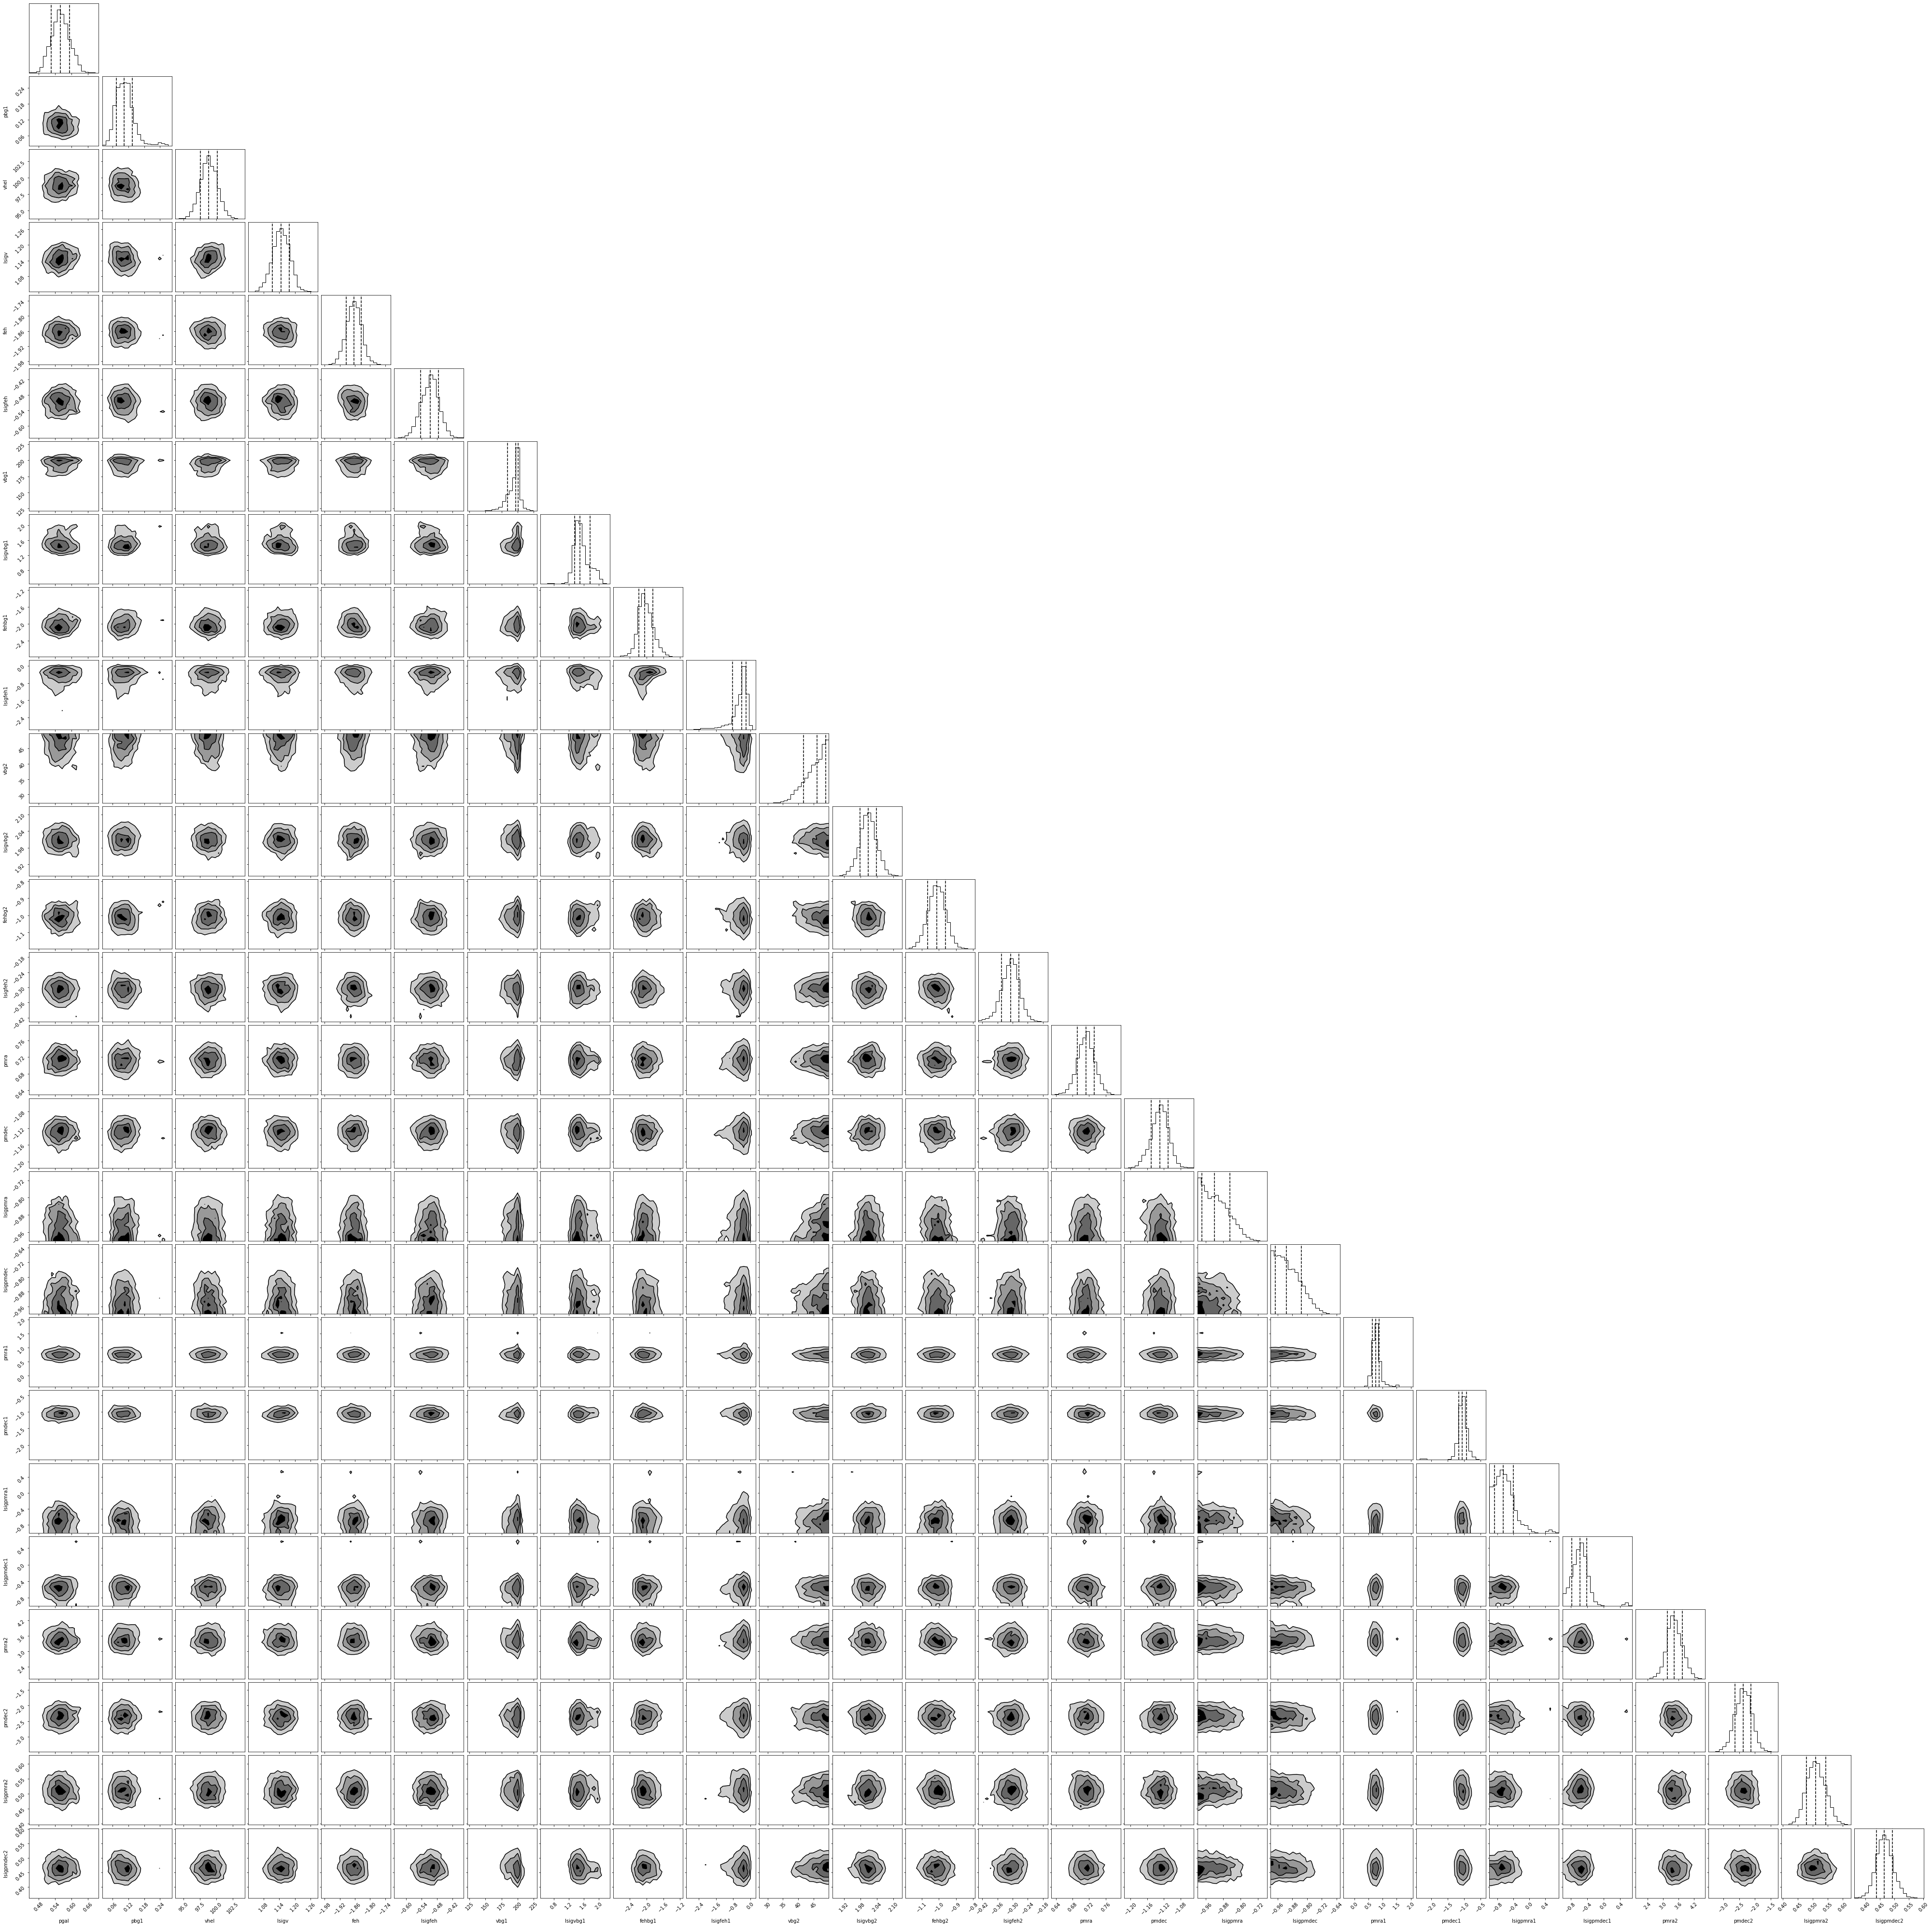

In [168]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})
#plt.savefig('SMCNOD_PM_1DModel_Cornerplot.png')

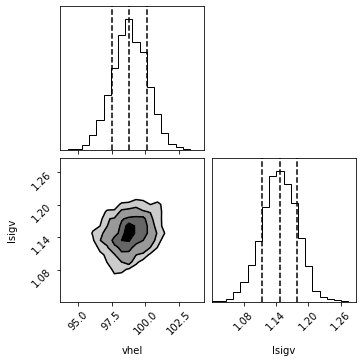

In [169]:
fig1 = corner.corner(outputs[:,2:4], labels=param_labels[2:4], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

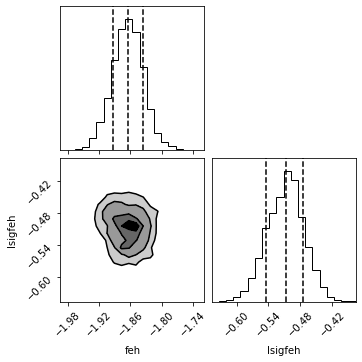

In [170]:
fig2 = corner.corner(outputs[:,4:6], labels=param_labels[4:6], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

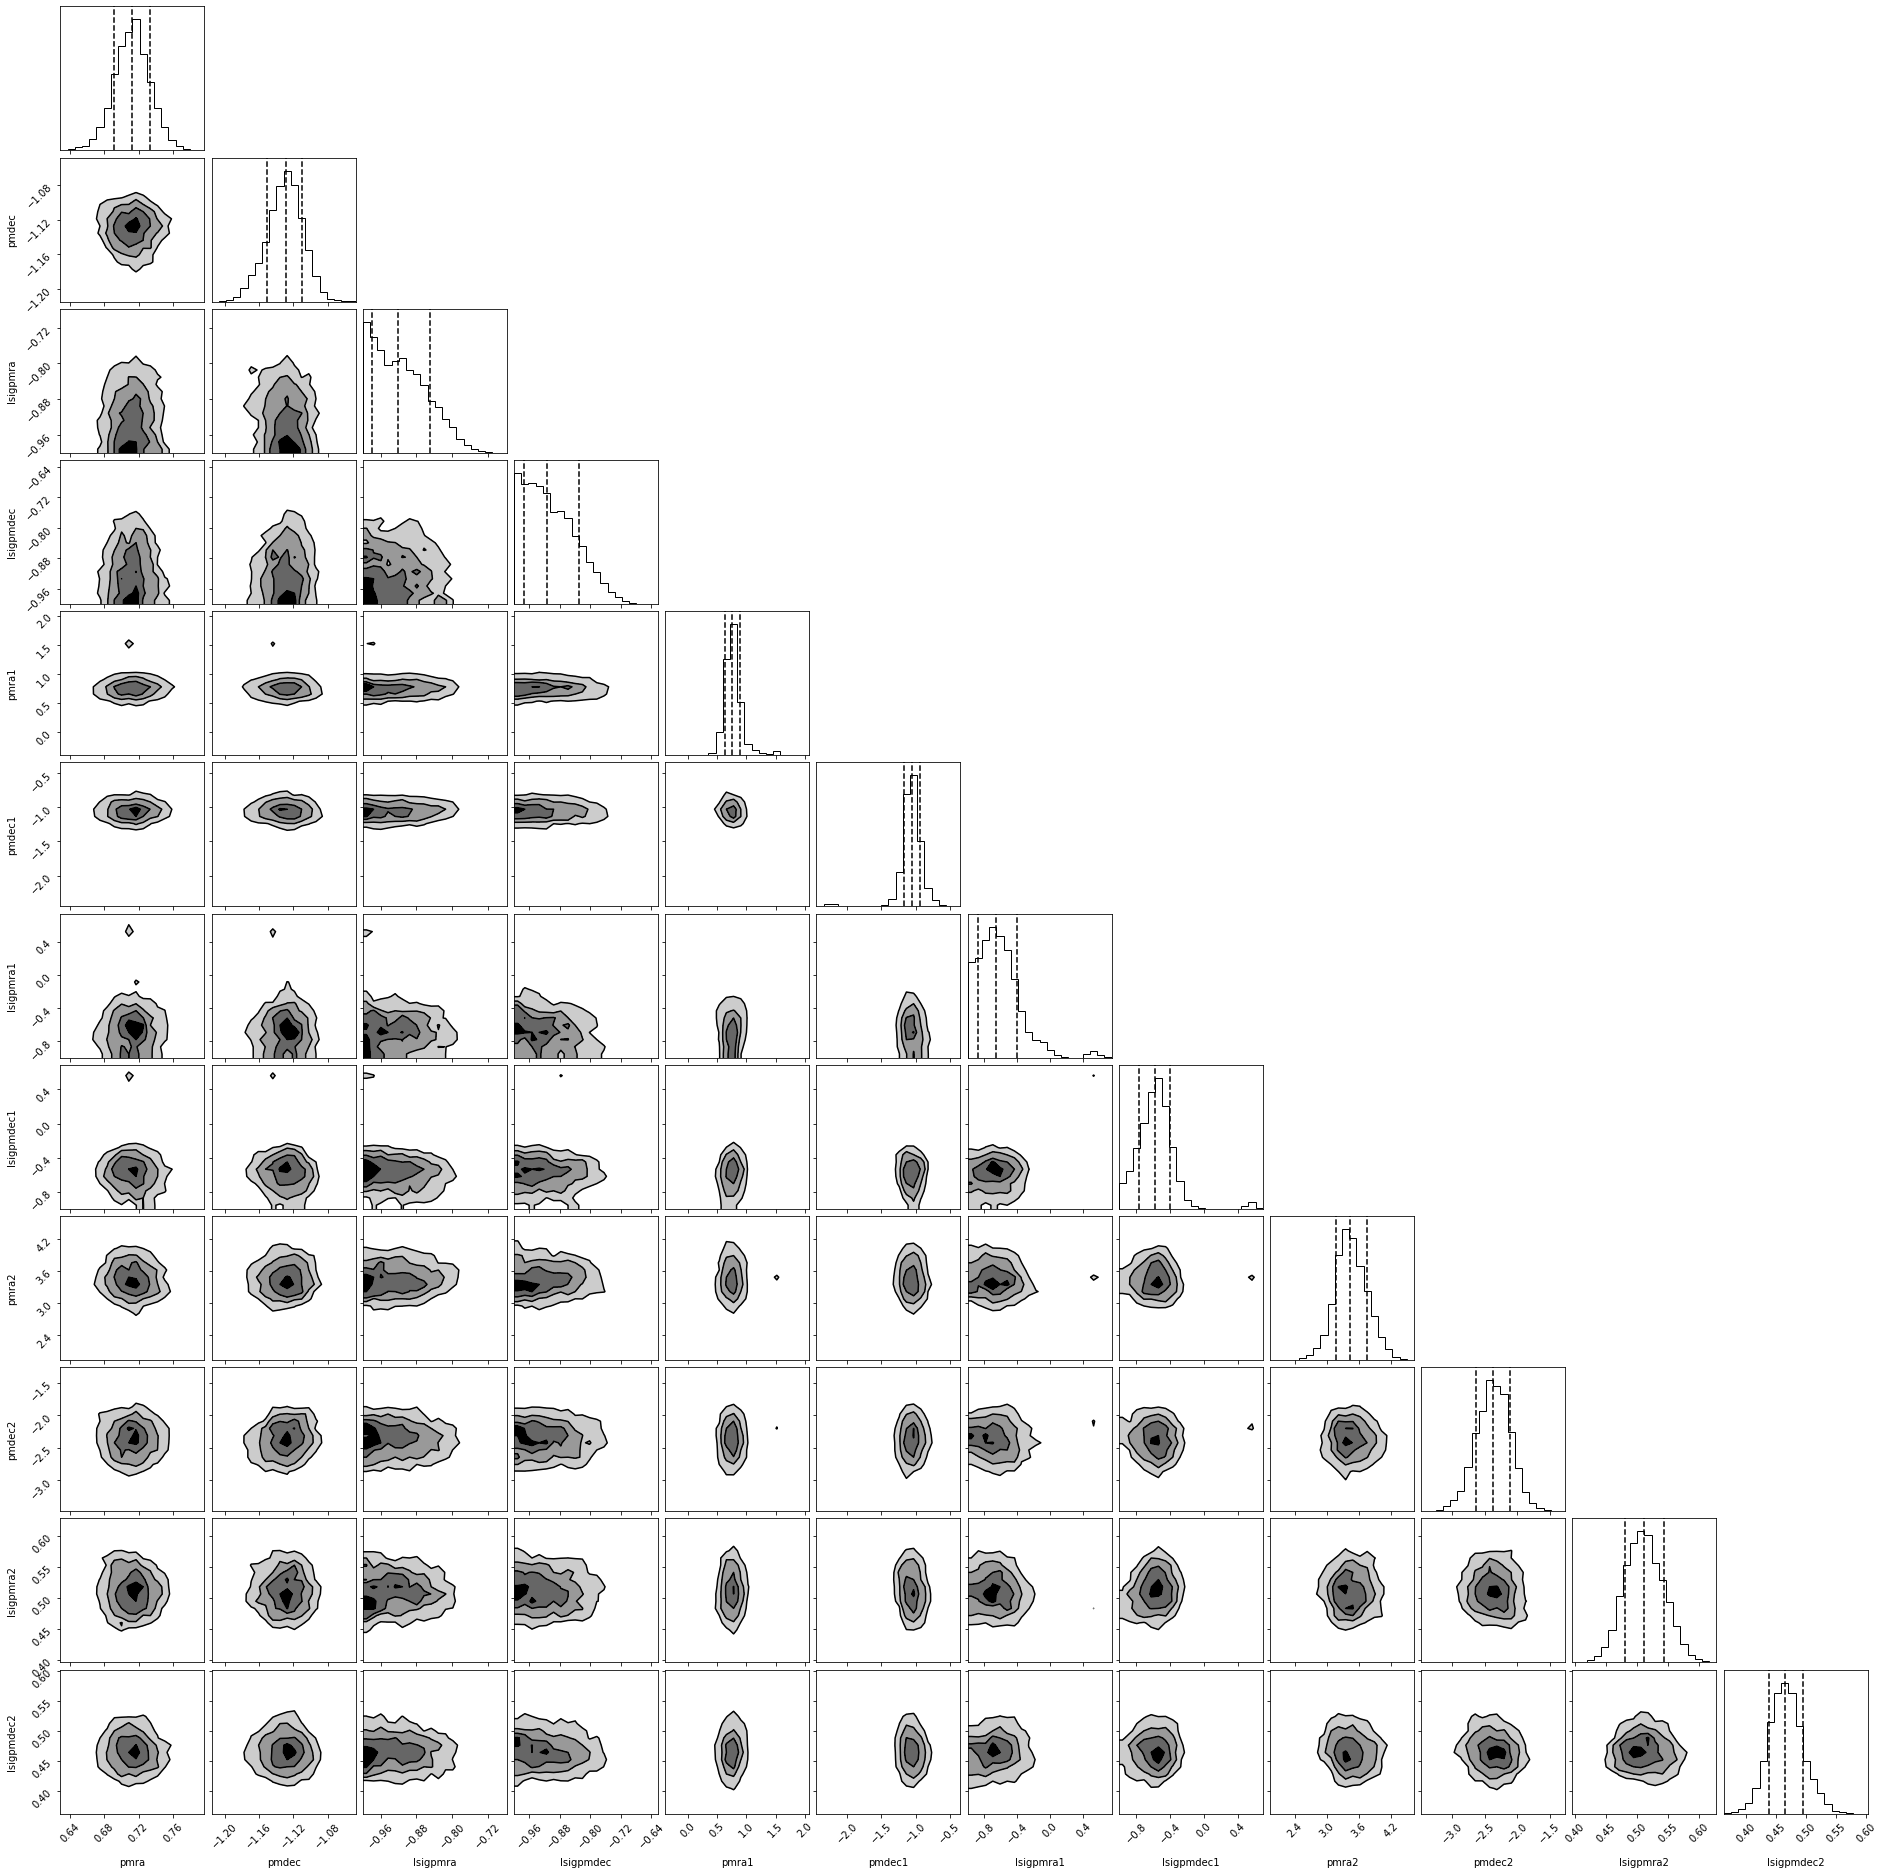

In [171]:
fig3 = corner.corner(outputs[:,14:], labels=param_labels[14:], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [172]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [173]:
meds, errs = process_chain(outputs)

In [174]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.559 0.033
pbg1 0.104 0.031
vhel 98.823 1.291
lsigv 1.147 0.032
feh -1.864 0.029
lsigfeh -0.506 0.035
vbg1 196.791 8.435
lsigvbg1 1.497 0.206
fehbg1 -2.037 0.170
lsigfeh1 -0.386 0.305
vbg2 46.104 3.643
lsigvbg2 2.008 0.030
fehbg2 -1.012 0.051
lsigfeh2 -0.308 0.034
pmra 0.713 0.020
pmdec -1.129 0.020
lsigpmra -0.921 0.065
lsigpmdec -0.913 0.072
pmra1 0.753 0.121
pmdec1 -1.057 0.116
lsigpmra1 -0.653 0.233
lsigpmdec1 -0.572 0.182
pmra2 3.435 0.296
pmdec2 -2.368 0.259
lsigpmra2 0.511 0.032
lsigpmdec2 0.465 0.028


If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [240]:
chain = es.flatchain
chain.shape

(128000, 26)

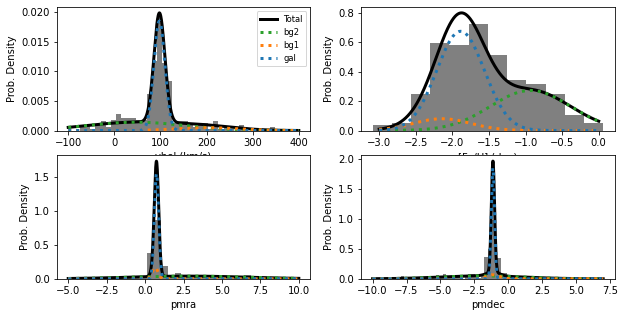

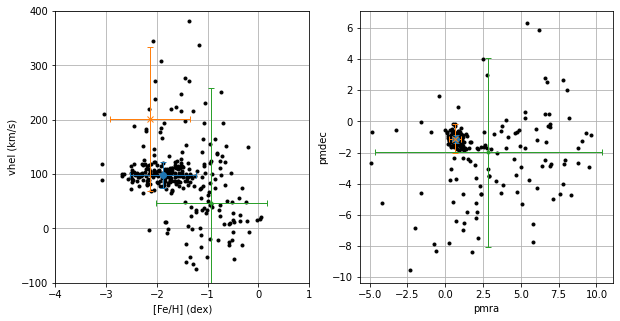

In [245]:
fig1 = plot_1d_distrs(chain[1])
fig2 = plot_2d_distr(chain[1])

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

In [246]:
chain_new = 10**(chain)
mean_vdisp = np.percentile(chain_new[:,3], 50)
std_vdisp = (np.percentile(chain_new[:,3], 84)-np.percentile(chain_new[:,3], 16))/2
mean_fehdisp = np.percentile(chain_new[:,5], 50)
std_fehdisp = (np.percentile(chain_new[:,5], 84)-np.percentile(chain_new[:,5], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  14.023081801568228 std_vdisp:  1.0431805291802245
mean_fehdisp:  0.31168333359675937 std_fehdisp:  0.024755040230752368


In [242]:
param_labels_1 = ["pgal = ","pbg1 = ",
                "vhel = ","lsigv = ","feh = ","lsigfeh = ",
                "vbg1 = ","lsigvbg1 = ","fehbg1 = ","lsigfeh1 = ",
                "vbg2 = ","lsigvbg2 = ","fehbg2 = ","lsigfeh2 = ",
                "pmra = ","pmdec = ","lsigpmra = ","lsigpmdec=",
                "pmra1 = ","pmdec1 = ","lsigpmra1 = ","lsigpmdec1 = ",
                "pmra2 = ","pmdec2 = ","lsigpmra2 = ","lsigpmdec2 = "]
def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)

for k,v in meds_1.items():
    print("{} {:.3f}".format(k, v))

pgal =  0.559
pbg1 =  0.104
vhel =  98.823
lsigv =  1.147
feh =  -1.864
lsigfeh =  -0.506
vbg1 =  196.791
lsigvbg1 =  1.497
fehbg1 =  -2.037
lsigfeh1 =  -0.386
vbg2 =  46.104
lsigvbg2 =  2.008
fehbg2 =  -1.012
lsigfeh2 =  -0.308
pmra =  0.713
pmdec =  -1.129
lsigpmra =  -0.921
lsigpmdec= -0.913
pmra1 =  0.753
pmdec1 =  -1.057
lsigpmra1 =  -0.653
lsigpmdec1 =  -0.572
pmra2 =  3.435
pmdec2 =  -2.368
lsigpmra2 =  0.511
lsigpmdec2 =  0.465
